# Data challenge - Yammer

**Background:**

- Yammer is a social network for communicating with coworkers
- Individuals share documents, updates, and ideas by posting them in groups
- Companies must pay license fees if they want access to administrative controls, including integration with user management systems like ActiveDirectory.

**Problem:**

Drop (about 15%) in weekly engagement between beginning August and September. Figure out why.

**Hypotheses**

2 possibilities:

A) Internal reasons - something that can be fixed

- diagnose that drop in engagment comes from existing users or decrease in signups
- there was an  overall outage in our platform = "catastrophic failures"
- only a specfic part is affected: specific device, specific part of platform, location 

for both try to narrow down to device or company see what distinguishes usage that does go down from one that does not go down.

B) External reasons - things that cannot be fixed/need to be investigated further

- check per company usage pattern
- people go on Vacation in August - compare southern and northern hemisphere usage patterns

In [1]:
### Load in some useful packages

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import qgrid
import seaborn as sns; sns.set() # this is another plotting program

pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.7.1.final.0
python-bits: 64
OS: Darwin
OS-release: 18.2.0
machine: x86_64
processor: i386
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8

pandas: 0.23.4
pytest: None
pip: 18.1
setuptools: 40.6.3
Cython: None
numpy: 1.15.4
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 7.2.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.5
pytz: 2018.9
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 3.0.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml: None
bs4: None
html5lib: None
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None


## Part 1: Data reading in and preprocessing

In [2]:
## read in the data + get an idea how many samples I have

users = pd.read_csv('yammer_users.csv')
events = pd.read_csv('yammer_events.csv')
emails = pd.read_csv('yammer_emails.csv')
rollup_periods = pd.read_csv('dimension_rollup_periods.csv')

print(users.shape)
print(events.shape)
print(emails.shape)
print(rollup_periods.shape)

(19066, 6)
(340832, 7)
(90389, 4)
(56002, 6)


In [14]:
# analyze the Events table for usage by country
# first look at the table and if datatypes were read in correctly

print(events.dtypes)
print(emails.dtypes)
print(rollup_periods.dtypes)
print(users.dtypes)

user_id               float64
occurred_at    datetime64[ns]
event_type             object
event_name             object
location               object
device                 object
user_type             float64
dtype: object
user_id        float64
occurred_at     object
action          object
user_type      float64
dtype: object
period_id    float64
time_id       object
pst_start     object
pst_end       object
utc_start     object
utc_end       object
dtype: object
user_id         float64
created_at       object
company_id      float64
language         object
activated_at     object
state            object
dtype: object


In [16]:
# need to convert the occured_at column into a datatime
from datetime import datetime # this calls the datetime package

events['occurred_at'] = pd.to_datetime(events['occurred_at'])

rollup_periods['time_id'] = pd.to_datetime(rollup_periods['time_id'])
rollup_periods['pst_start'] = pd.to_datetime(rollup_periods['pst_start'])
rollup_periods['pst_end'] = pd.to_datetime(rollup_periods['pst_end'])
rollup_periods['utc_start'] = pd.to_datetime(rollup_periods['utc_start'])
rollup_periods['utc_end'] = pd.to_datetime(rollup_periods['utc_end'])


print(events.dtypes)
print(rollup_periods.dtypes)

user_id               float64
occurred_at    datetime64[ns]
event_type             object
event_name             object
location               object
device                 object
user_type             float64
dtype: object
period_id           float64
time_id      datetime64[ns]
pst_start    datetime64[ns]
pst_end      datetime64[ns]
utc_start    datetime64[ns]
utc_end      datetime64[ns]
dtype: object


In [161]:
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [162]:
users['created_at'] = pd.to_datetime(users['created_at'])
users['activated_at'] = pd.to_datetime(users['activated_at'])
users.dtypes

user_id                float64
created_at      datetime64[ns]
company_id             float64
language                object
activated_at    datetime64[ns]
state                   object
dtype: object

In [266]:
emails['occurred_at'] = pd.to_datetime(emails['occurred_at'])

In [267]:
emails.dtypes

user_id               float64
occurred_at    datetime64[ns]
action                 object
user_type             float64
dtype: object

In [6]:
events.location.unique()

array(['Japan', 'Netherlands', 'Austria', 'Finland', 'United Kingdom',
       'India', 'United States', 'France', 'Iran', 'Germany', 'Australia',
       'Brazil', 'Thailand', 'Russia', 'Taiwan', 'Canada', 'Spain',
       'Israel', 'Colombia', 'Iraq', 'Indonesia', 'Greece', 'Norway',
       'United Arab Emirates', 'Korea', 'Venezuela', 'Belgium',
       'Saudi Arabia', 'Poland', 'Sweden', 'Denmark', 'Mexico', 'Italy',
       'Egypt', 'Nigeria', 'Pakistan', 'Portugal', 'Singapore',
       'South Africa', 'Hong Kong', 'Switzerland', 'Turkey', 'Chile',
       'Ireland', 'Argentina', 'Malaysia', 'Philippines'], dtype=object)

In [7]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


In [10]:
# count total events/country

events['location'].value_counts()

United States           94728
Japan                   26046
Germany                 23524
France                  17364
United Kingdom          16475
Russia                  12226
Italy                   11790
Brazil                  11240
India                    9620
Canada                   9126
Mexico                   9106
Australia                7494
Korea                    7180
Indonesia                6224
Spain                    5874
Netherlands              4494
Saudi Arabia             4104
Sweden                   3901
Poland                   3803
Switzerland              3760
Taiwan                   3600
Iran                     3122
Belgium                  2822
Malaysia                 2529
Austria                  2494
Turkey                   2432
United Arab Emirates     2343
South Africa             2324
Egypt                    2258
Denmark                  2191
Israel                   2130
Norway                   2020
Thailand                 2008
Colombia  

In [17]:
rollup_periods.head()

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
0,1.0,2013-01-01,2013-01-01,2013-01-02,2013-01-01 08:00:00,2013-01-02 08:00:00
1,1.0,2013-01-02,2013-01-02,2013-01-03,2013-01-02 08:00:00,2013-01-03 08:00:00
2,1.0,2013-01-03,2013-01-03,2013-01-04,2013-01-03 08:00:00,2013-01-04 08:00:00
3,1.0,2013-01-04,2013-01-04,2013-01-05,2013-01-04 08:00:00,2013-01-05 08:00:00
4,1.0,2013-01-05,2013-01-05,2013-01-06,2013-01-05 08:00:00,2013-01-06 08:00:00


In [18]:
# don't really know in which unit the time in events is  (utc vs pst) assumed utc since
# it's more standardized and the world doesn't care that much about pst and it's about 
# time that Americans switched to the metric system


events['time_id'] = events['occurred_at'].apply(lambda time: rollup_periods['time_id'][(rollup_periods['utc_start'] <= time) & (rollup_periods['utc_end'] > time)].values[0])
events.head()


,user_id,occurred_at,event_type,event_name,location,device,user_type,time_id
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-05-02
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-05-02
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-05-02
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-05-02
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-05-02


In [20]:
# the process before took a long time so better save the output as a .csv
events.to_csv('backup_events.csv')

In [21]:
events.dtypes

user_id               float64
occurred_at    datetime64[ns]
event_type             object
event_name             object
location               object
device                 object
user_type             float64
time_id        datetime64[ns]
dtype: object

In [26]:
### curious what's in each column

print('event_type')
print(events['event_type'].value_counts())
print('event_name')
print(events['event_name'].value_counts())
print('device')
print(events['device'].value_counts())


event_type
engagement     321575
signup_flow     19257
Name: event_type, dtype: int64
event_name
home_page                 94065
like_message              59248
view_inbox                55936
login                     38610
send_message              33105
search_autocomplete       17820
search_run                13019
create_user                7298
enter_email                4407
enter_info                 3872
complete_signup            3680
search_click_result_2      1499
search_click_result_1      1413
search_click_result_4      1264
search_click_result_3      1134
search_click_result_5       968
search_click_result_6       805
search_click_result_9       784
search_click_result_7       709
search_click_result_8       690
search_click_result_10      506
Name: event_name, dtype: int64
device
macbook pro               59948
lenovo thinkpad           38679
macbook air               28104
iphone 5                  27134
dell inspiron notebook    20476
samsung galaxy s4         19594
n

In [28]:
#in which range do we have data
print(events['time_id'].min())
print(events['time_id'].max())

2014-04-30 00:00:00
2014-08-31 00:00:00


In [38]:
# sort the events dataframe, so that it's easier to plot

events = events.sort_values(by='time_id', ascending=True)
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,time_id
145967,5830.0,2014-05-01 03:10:17,engagement,search_click_result_6,Philippines,macbook pro,3.0,2014-04-30
261539,11276.0,2014-05-01 03:50:19,engagement,view_inbox,Indonesia,dell inspiron desktop,2.0,2014-04-30
261538,11276.0,2014-05-01 03:49:43,engagement,home_page,Indonesia,dell inspiron desktop,2.0,2014-04-30
261537,11276.0,2014-05-01 03:49:09,engagement,like_message,Indonesia,dell inspiron desktop,2.0,2014-04-30
261536,11276.0,2014-05-01 03:48:38,engagement,send_message,Indonesia,dell inspiron desktop,2.0,2014-04-30


In [41]:
events_over_time = events[events.event_type == 'engagement']
events_over_time = events_over_time['time_id'].value_counts()
events_over_time.head()

2014-07-18    4293
2014-07-31    4215
2014-07-25    4135
2014-06-27    4028
2014-07-30    3974
Name: time_id, dtype: int64

## Part 2 - checking of hypotheses

## A) Internal reasons - something that can be fixed

### - diagnose that drop in engagment comes from existing users or decrease in signups

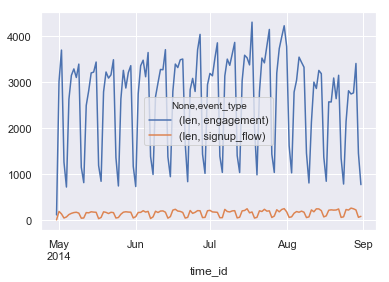

In [279]:
pd.pivot_table(events,index=["time_id"], values = 'device', columns=["event_type"],aggfunc=[len]).plot(legend=True)

### - there was an overall outage in our platform = "catastrophic failures"

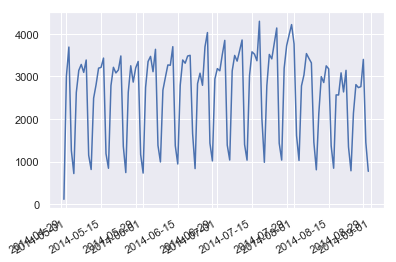

In [42]:
# this is the total number of engagments per time period - dip makes sense
# this is probably because of weekends -
events_over_time.plot()

In [45]:
users_over_time = events[events.event_type == 'engagement']
users_over_time = users_over_time.groupby('time_id')['user_id'].nunique()
users_over_time

time_id
2014-04-30     13
2014-05-01    306
2014-05-02    343
2014-05-03    144
2014-05-04     83
2014-05-05    261
2014-05-06    313
2014-05-07    315
2014-05-08    316
2014-05-09    342
2014-05-10    133
2014-05-11     92
2014-05-12    268
2014-05-13    304
2014-05-14    305
2014-05-15    337
2014-05-16    376
2014-05-17    131
2014-05-18     99
2014-05-19    302
2014-05-20    330
2014-05-21    323
2014-05-22    315
2014-05-23    360
2014-05-24    158
2014-05-25     82
2014-05-26    285
2014-05-27    338
2014-05-28    289
2014-05-29    321
             ... 
2014-08-02    180
2014-08-03    121
2014-08-04    304
2014-08-05    351
2014-08-06    372
2014-08-07    377
2014-08-08    365
2014-08-09    166
2014-08-10     94
2014-08-11    270
2014-08-12    327
2014-08-13    343
2014-08-14    333
2014-08-15    349
2014-08-16    172
2014-08-17    112
2014-08-18    299
2014-08-19    307
2014-08-20    346
2014-08-21    317
2014-08-22    356
2014-08-23    159
2014-08-24    102
2014-08-25    270
20

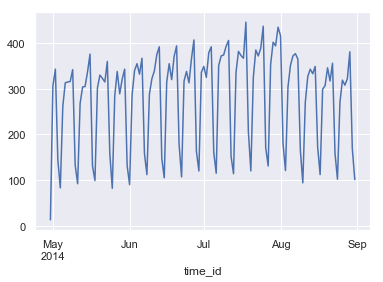

In [44]:
users_over_time.plot()
# this is unique users over time

# same dipping trend - so the fact that the pattern still seems normal but reduced doesn't 
# that there is general problems with the platform

### Answer- daily usagepattern still looks the same as in August - no catastrophic failure
specifically there is a spike during the week and a dip on the weekend.

### - only a specfic part is affected: specific device, specific part of platform, location 

the following tables always plot a specific feature per montly usage. I compared July to August to identify if the dip happens in a specific case or is a general feature.

### Event type of engagement

In [287]:
pd.pivot_table(events,index=["event_name"], values = 'device', columns=[pd.Grouper(key='time_id', freq='M')],aggfunc=[len])

len                                            
time_id                2014-04-30 2014-05-31 2014-06-30 2014-07-31 2014-08-31
event_name                                                                   
complete_signup               2.0      777.0      877.0     1001.0     1023.0
create_user                   5.0     1593.0     1735.0     1985.0     1980.0
enter_email                   2.0      953.0     1071.0     1193.0     1188.0
enter_info                    2.0      823.0      929.0     1047.0     1071.0
home_page                    38.0    22667.0    23029.0    26796.0    21535.0
like_message                 22.0    14738.0    14490.0    16706.0    13292.0
login                        13.0     8976.0     9346.0    11032.0     9243.0
search_autocomplete           3.0     3988.0     4145.0     5225.0     4459.0
search_click_result_1         NaN      354.0      353.0      432.0      274.0
search_click_result_10        NaN      115.0      125.0      163.0      103.0
search_click_result_2         NaN      382.0      372.0      450.0      295.0
search_click_result_3         1.0      301.0      292.0      306.0      234.0
search_click_result_4         1.0      346.0      299.0      361.0      257.0
search_click_result_5         NaN      265.0      255.0      266.0      182.0
search_click_result_6         1.0      224.0      163.0      248.0      169.0
search_click_result_7         NaN      191.0      165.0      200.0      153.0
search_click_result_8         NaN      163.0      181.0      212.0      134.0
search_click_result_9         NaN      221.0      184.0      238.0      141.0
search_run                    3.0     3209.0     3170.0     3817.0     2820.0
send_message                 12.0     8220.0     8199.0     9371.0     7303.0
view_inbox                   23.0    13234.0    13602.0    16107.0    12970.0

### Emails

this is just looking at events within emails

In [292]:
pd.pivot_table(emails, index=["action"], values='user_id', columns=[pd.Grouper(key='occurred_at', freq='M')],aggfunc=[len])

len                                 
occurred_at             2014-05-31 2014-06-30 2014-07-31 2014-08-31
action                                                             
email_clickthrough          2023.0     2274.0     2721.0     1992.0
email_open                  4212.0     4658.0     5611.0     5978.0
sent_reengagement_email      758.0      889.0      933.0     1073.0
sent_weekly_digest         11730.0    13155.0    15902.0    16480.0

this is just looking at events within emails after joining to the engagements from the table

In [293]:
pd.pivot_table(pd.merge(emails, events, on='user_id', how = 'left', sort=False), values= 'device', index=["action"],columns=[pd.Grouper(key='time_id', freq='M')],aggfunc=[len])


len                                            
time_id                 2014-04-30 2014-05-31 2014-06-30 2014-07-31 2014-08-31
action                                                                        
email_clickthrough             177     170674     188163     214053     157831
email_open                     391     375772     381418     419470     294044
sent_reengagement_email         15      25438      37237      48839      44397
sent_weekly_digest            1309    1071439    1030003    1096635     713362

### Device used

In [282]:
pd.pivot_table(events,index=["device"], values= 'event_name',columns=[pd.Grouper(key='time_id', freq='M')],aggfunc=[len])

len                                            
time_id                2014-04-30 2014-05-31 2014-06-30 2014-07-31 2014-08-31
device                                                                       
acer aspire desktop          12.0     1209.0     1177.0     1404.0     1600.0
acer aspire notebook          NaN     2028.0     2178.0     2563.0     2603.0
amazon fire phone             NaN      570.0      563.0      489.0      676.0
asus chromebook               NaN     2166.0     2511.0     2663.0     2674.0
dell inspiron desktop        13.0     2473.0     2927.0     2983.0     2173.0
dell inspiron notebook        NaN     4776.0     4861.0     5510.0     5329.0
hp pavilion desktop           NaN     1742.0     2573.0     2838.0     2127.0
htc one                       NaN     1340.0     1093.0     1261.0      791.0
ipad air                      NaN     2636.0     2491.0     2868.0     1999.0
ipad mini                     NaN     1530.0     1358.0     1836.0     1171.0
iphone 4s                    12.0     2448.0     2194.0     3298.0     2145.0
iphone 5                     22.0     6411.0     6854.0     8150.0     5697.0
iphone 5s                     6.0     4250.0     4115.0     4825.0     3509.0
kindle fire                   NaN     1199.0     1147.0     1353.0      581.0
lenovo thinkpad              10.0     9234.0     8564.0    11391.0     9480.0
mac mini                      NaN     1065.0     1067.0     1180.0     1310.0
macbook air                   9.0     6477.0     6899.0     7912.0     6807.0
macbook pro                  43.0    14778.0    13587.0    16116.0    15424.0
nexus 10                      NaN     1293.0     1607.0     1434.0     1112.0
nexus 5                       1.0     4829.0     4742.0     4464.0     3213.0
nexus 7                       NaN     1437.0     1932.0     1976.0     1550.0
nokia lumia 635               NaN     1101.0     1718.0     1906.0     1155.0
samsumg galaxy tablet         NaN      371.0      499.0      633.0      417.0
samsung galaxy note           NaN      797.0      843.0      641.0      540.0
samsung galaxy s4             NaN     4805.0     4605.0     6178.0     4006.0
windows surface               NaN      775.0      877.0     1284.0      737.0

### User type

In [285]:
pd.pivot_table(events,index=["user_type"], values='device', columns=[pd.Grouper(key='time_id', freq='M')],aggfunc=[len])

len                                            
time_id   2014-04-30 2014-05-31 2014-06-30 2014-07-31 2014-08-31
user_type                                                       
1.0               74      53557      52304      59402      45325
2.0               31      14230      14694      18302      15321
3.0               14      10584      12249      15227      13941

### Location where engagment was recorded

In [283]:
pd.pivot_table(events,index=["location"], values= 'device', columns=[pd.Grouper(key='time_id', freq='M')],aggfunc=[len])

len                                            
time_id              2014-04-30 2014-05-31 2014-06-30 2014-07-31 2014-08-31
location                                                                   
Argentina                   NaN      227.0      512.0      332.0      646.0
Australia                  20.0     1811.0     1934.0     1836.0     1893.0
Austria                     NaN      382.0      577.0      927.0      608.0
Belgium                     NaN      948.0      557.0      865.0      452.0
Brazil                      NaN     2679.0     2751.0     3229.0     2581.0
Canada                      9.0     2651.0     2222.0     2623.0     1621.0
Chile                       NaN      134.0      167.0      485.0      306.0
Colombia                    NaN      407.0      375.0      632.0      531.0
Denmark                     NaN      289.0      332.0      655.0      915.0
Egypt                       NaN      628.0      640.0      443.0      547.0
Finland                     NaN      542.0      409.0      520.0      455.0
France                      NaN     4022.0     4601.0     5314.0     3427.0
Germany                     NaN     5440.0     5287.0     7316.0     5481.0
Greece                      NaN      147.0      132.0      425.0      285.0
Hong Kong                   6.0      440.0      363.0      351.0      365.0
India                       9.0     2412.0     2153.0     3003.0     2043.0
Indonesia                  13.0     1612.0     1581.0     1691.0     1327.0
Iran                        NaN      695.0      875.0      783.0      769.0
Iraq                        NaN      276.0      479.0      280.0      365.0
Ireland                     NaN      252.0      238.0      229.0      354.0
Israel                      NaN      460.0      568.0      545.0      557.0
Italy                       NaN     2807.0     2397.0     3737.0     2849.0
Japan                      21.0     5977.0     6537.0     7469.0     6042.0
Korea                       NaN     1927.0     1716.0     2044.0     1493.0
Malaysia                    NaN      657.0      490.0      702.0      680.0
Mexico                      NaN     2532.0     2188.0     2560.0     1826.0
Netherlands                 NaN      749.0     1039.0     1232.0     1474.0
Nigeria                     NaN      511.0      269.0      454.0      408.0
Norway                      NaN      658.0      527.0      532.0      303.0
Pakistan                    NaN      240.0      185.0      286.0      324.0
Philippines                11.0      258.0      300.0      414.0      390.0
Poland                      6.0     1149.0      925.0      817.0      906.0
Portugal                    NaN      352.0      238.0      355.0      391.0
Russia                      NaN     3747.0     2561.0     3130.0     2788.0
Saudi Arabia                NaN      931.0     1229.0     1138.0      806.0
Singapore                   NaN      198.0      343.0      616.0      340.0
South Africa                NaN      306.0      519.0      775.0      724.0
Spain                       NaN     1864.0     1703.0     1115.0     1192.0
Sweden                      7.0      645.0     1252.0     1062.0      935.0
Switzerland                 NaN      722.0      959.0     1368.0      711.0
Taiwan                      NaN      906.0      905.0      967.0      822.0
Thailand                    NaN      555.0      665.0      529.0      259.0
Turkey                      NaN      366.0      493.0      777.0      796.0
United Arab Emirates        NaN      759.0      614.0      444.0      526.0
United Kingdom              2.0     4819.0     4050.0     4139.0     3465.0
United States              24.0    21177.0    23744.0    27327.0    22456.0
Venezuela                   NaN      474.0      381.0      683.0      392.0

### Language

In [284]:
pd.pivot_table(pd.merge(users, events, on='user_id', how = 'left', sort=False),index=["language"],values='activated_at',columns=[pd.Grouper(key='time_id', freq='M')],aggfunc=[len])

len                                            
time_id   2014-04-30 2014-05-31 2014-06-30 2014-07-31 2014-08-31
language                                                        
arabic           NaN     3173.0     3066.0     3230.0     2634.0
chinese         41.0     3592.0     3564.0     3517.0     2870.0
english         56.0    38619.0    41353.0    47973.0    39710.0
french           1.0     6813.0     6928.0     8870.0     6186.0
german           NaN     4968.0     4953.0     6796.0     5180.0
indian           9.0     2405.0     2307.0     2761.0     1954.0
italian          NaN     2151.0     1553.0     2248.0     1800.0
japanese        21.0     5550.0     6079.0     6955.0     5775.0
korean           NaN     1344.0     1256.0     1388.0     1012.0
portugese        NaN     2138.0     2019.0     2651.0     2185.0
russian          NaN     3089.0     2186.0     2613.0     2496.0
spanish          NaN     7898.0     7718.0     8154.0     7024.0

## Conclusion:

   - there is no specific platform that is mostly affected (both Mac/Windows Mobile and Desktop are affected)
   - no specific pattern by language or location
   - there is no specic pattern by user-type (whatever that means)
   - the only thing that stood out that email sent and received was unchanded but fewer people clicked links in the emails - also something is going on in the engagement table when linkin that to the emails - would need some more time to figure this out...

## B) External reasons - things that cannot be fixed/need to be investigated further

### - check per company usage pattern - 
if the pattern is specific for companies maybe they are changing their business practices which is decreasing our user engagement

In [197]:
pd.pivot_table(pd.merge(users, events, on='user_id', how = 'left', sort=False), values = 'activated_at', index=["company_id"],columns=[pd.Grouper(key='time_id', freq='M')],aggfunc=[len])


len                                            
time_id    2014-04-30 2014-05-31 2014-06-30 2014-07-31 2014-08-31
company_id                                                       
1.0               NaN     5751.0     4450.0     5584.0     4454.0
2.0               NaN     2530.0     2323.0     3584.0     1972.0
3.0               NaN     1386.0     1814.0     1470.0     1934.0
4.0               NaN      934.0      853.0     1306.0      993.0
5.0               NaN      284.0      903.0     1122.0      735.0
6.0               NaN      705.0      932.0     1300.0      523.0
7.0               NaN      341.0      424.0      892.0      393.0
8.0               NaN      563.0      566.0      765.0      974.0
9.0               NaN      516.0      550.0      695.0      328.0
10.0              NaN      302.0      504.0      482.0      419.0
11.0              NaN      401.0      238.0      455.0      450.0
12.0              NaN      586.0      657.0      273.0      105.0
13.0              NaN      250.0      535.0      590.0      443.0
14.0              NaN      347.0      340.0      374.0      319.0
15.0              NaN      120.0      126.0      435.0      120.0
16.0              NaN      227.0      232.0      180.0      170.0
17.0              NaN      177.0      251.0      304.0      162.0
18.0              NaN      292.0      304.0      253.0      126.0
19.0              NaN      103.0       72.0       97.0      236.0
20.0              NaN      141.0      285.0      326.0      252.0
21.0              NaN      105.0      176.0       97.0       41.0
22.0              NaN       35.0       13.0      130.0      116.0
23.0              NaN      345.0       49.0      244.0      254.0
24.0              NaN      155.0       35.0      349.0       34.0
25.0              NaN      306.0      179.0      187.0      188.0
26.0              NaN      123.0      293.0       89.0      275.0
27.0              NaN       99.0        8.0      147.0       47.0
28.0              NaN      346.0      181.0      306.0      190.0
29.0              NaN      150.0      168.0      182.0      181.0
30.0              NaN       49.0       49.0       65.0       34.0
...               ...        ...        ...        ...        ...
13151.0           NaN       53.0        9.0        NaN      106.0
13152.0           NaN        NaN        NaN        2.0        NaN
13153.0           NaN        NaN        1.0        NaN        NaN
13154.0           NaN        NaN        NaN        NaN        8.0
13155.0           NaN        NaN        NaN        1.0        NaN
13157.0           NaN        NaN        1.0        NaN        NaN
13159.0           NaN       83.0        NaN        NaN        NaN
13160.0           NaN        NaN       21.0        NaN        NaN
13162.0           NaN        1.0        NaN        NaN        NaN
13165.0           NaN       72.0      135.0       85.0       38.0
13173.0           NaN        NaN        NaN       74.0        5.0
13174.0           NaN        NaN        NaN        NaN        1.0
13175.0           NaN        NaN        NaN        NaN        1.0
13176.0           NaN        NaN        3.0        NaN        NaN
13177.0           NaN       47.0       13.0       57.0        NaN
13178.0           NaN       23.0        NaN        NaN        NaN
13179.0           NaN      130.0        4.0        NaN       87.0
13180.0           NaN        NaN        NaN        NaN        1.0
13181.0           NaN        NaN       16.0        NaN        NaN
13183.0           NaN        NaN       19.0        NaN        NaN
13184.0           NaN        NaN        NaN       10.0       11.0
13185.0           NaN        NaN        NaN        NaN      109.0
13187.0           NaN        NaN       90.0        NaN        NaN
13188.0           NaN       36.0        NaN       96.0       59.0
13191.0           NaN        NaN        NaN       18.0        NaN
13192.0           NaN        NaN        NaN       40.0        NaN
13193.0           NaN        NaN        6.0        NaN    

In [149]:
## to get an idea how many users are there by company
users.groupby(['company_id']).count() 

,user_id,created_at,language,activated_at,state
company_id,,,,,
1.0,1036,1036,1036,510,1036
2.0,477,477,477,231,477
3.0,307,307,307,158,307
4.0,220,220,220,97,220
5.0,172,172,172,87,172
6.0,151,151,151,80,151
7.0,122,122,122,61,122
8.0,129,129,129,64,129
9.0,96,96,96,49,96


Interesting pattern: there are definitly companies that more of a dip in engagment than others

compare company 3 to company 2 (about simliar size), also look at company 1 since it is the biggest one

company 2 = similar size but has dip in engagement
company 3 = has no dip in engagment

In [187]:
# make new df with 2 companies

company1 = users.loc[users['company_id'] == 1.0]
company2 = users.loc[users['company_id'] == 2.0]
company3 = users.loc[users['company_id'] == 3.0]

company1.size

6216

### Plotting activated users over time for company 1, 2 and 3

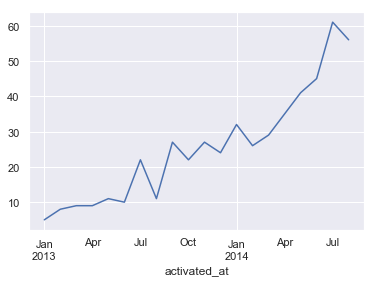

In [215]:
company1.set_index('activated_at').resample('M')["state"].count().plot()

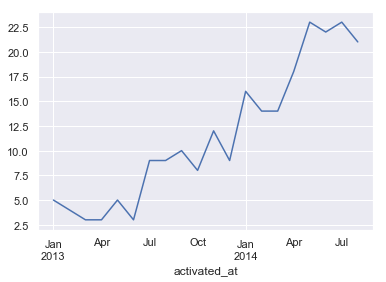

In [216]:
company2.set_index('activated_at').resample('M')["state"].count().plot()

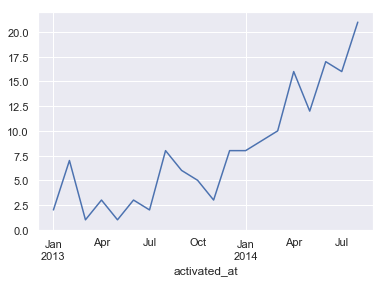

In [217]:
company3.set_index('activated_at').resample('M')["state"].count().plot()

#### There seems to be a dip in activation also in August of 2013 for company 1, so maybe the dip in engagment is specific for some companies. Company2 and 3 had not that many users.

### Looked also at daily use engagment patterns for company 1, 2 and 3 to see if there is a different pattern in cycling

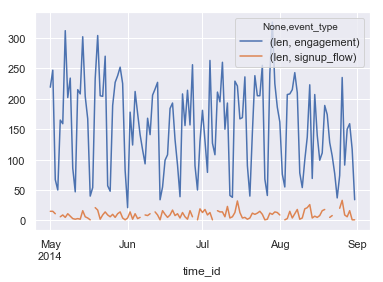

In [245]:
pd.pivot_table(pd.merge(company1, events, on='user_id', how = 'left', sort=False),values='activated_at', index=[pd.Grouper(key='time_id', freq='D')], columns=["event_type"],aggfunc=[len]).plot()


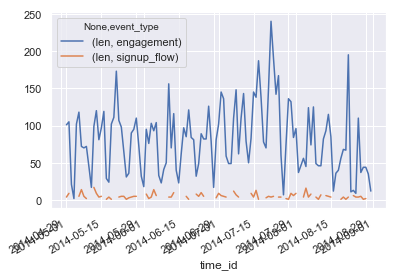

In [294]:
pd.pivot_table(pd.merge(company2, events, on='user_id', how = 'left', sort=False),values='activated_at', index=[pd.Grouper(key='time_id', freq='D')], columns=["event_type"],aggfunc=[len]).plot()

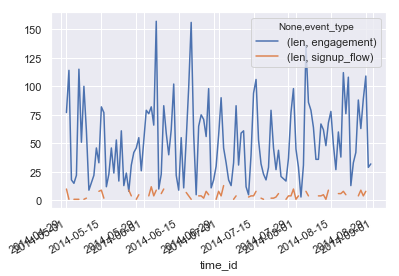

In [248]:
pd.pivot_table(pd.merge(company3, events, on='user_id', how = 'left', sort=False),values='activated_at', index=[pd.Grouper(key='time_id', freq='D')], columns=["event_type"],aggfunc=[len]).plot()


#### cycling patterns for the companies didn't appear that much different. there might be some trend that company 1 and 2 might have been working up to some deadline in July (weekend usages increased) so maybe they are taking a break in August? 

In [198]:
company1.head()

,user_id,created_at,company_id,language,activated_at,state
9,9.0,2013-01-01 08:04:17,1.0,french,NaT,pending
47,47.0,2013-01-04 10:39:31,1.0,indian,2013-01-04 10:41:06,active
74,74.0,2013-01-08 21:11:48,1.0,english,NaT,pending
78,78.0,2013-01-08 12:58:44,1.0,english,2013-01-08 13:00:19,active
86,86.0,2013-01-09 13:24:02,1.0,indian,2013-01-09 13:25:27,active



### - people go on Vacation in August - compare southern and northern hemisphere usage patterns -

looked at the countries with a decent user base and then aggregated countries that don't have holidays in August. 
https://en.wikipedia.org/wiki/Summer_vacation

In [56]:
events['location'].value_counts()

United States           94728
Japan                   26046
Germany                 23524
France                  17364
United Kingdom          16475
Russia                  12226
Italy                   11790
Brazil                  11240
India                    9620
Canada                   9126
Mexico                   9106
Australia                7494
Korea                    7180
Indonesia                6224
Spain                    5874
Netherlands              4494
Saudi Arabia             4104
Sweden                   3901
Poland                   3803
Switzerland              3760
Taiwan                   3600
Iran                     3122
Belgium                  2822
Malaysia                 2529
Austria                  2494
Turkey                   2432
United Arab Emirates     2343
South Africa             2324
Egypt                    2258
Denmark                  2191
Israel                   2130
Norway                   2020
Thailand                 2008
Colombia  

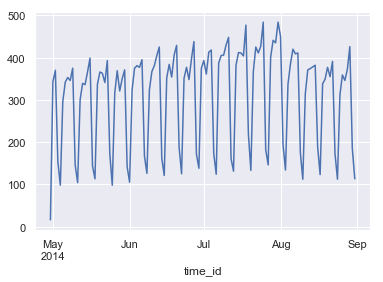

In [62]:
users_northern_HM = events[(events.location != 'India')|(events.location != 'Australia') | (events.location != 'Brazil') | (events.location != 'South Africa') | (events.location != 'Chile' )]
users_northern_HM.groupby('time_id')['user_id'].nunique().plot()

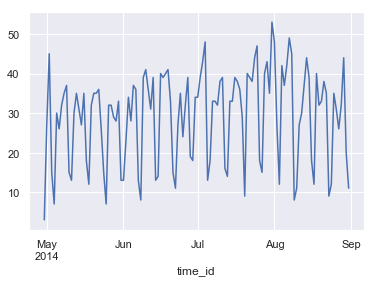

In [61]:
users_southern_HM = events[(events.location == 'India')|(events.location == 'Australia') | (events.location == 'Brazil') | (events.location == 'South Africa') | (events.location == 'Chile' )]
users_southern_HM.groupby('time_id')['user_id'].nunique().plot()


In [82]:
### look at engagement per month for southern hemisphere

users_southern_HM[users_southern_HM.event_type == 'engagement'].resample('M').count()

,user_id,occurred_at,event_type,event_name,location,device,user_type
time_id,,,,,,,
2014-04-30,29,29,29,29,29,29,29
2014-05-31,6957,6957,6957,6957,6957,6957,6957
2014-06-30,7149,7149,7149,7149,7149,7149,7149
2014-07-31,8833,8833,8833,8833,8833,8833,8833
2014-08-31,7008,7008,7008,7008,7008,7008,7008


#### there still is a dip in engagment in the "southern hemisphere" countries so elevated vacation in August that doesn't explain decreased engagemnt

# Overall Conclusion:

- no catastrophic failure of platform
- no device specific, language specific, country specific outage
- mostly website affected and not email
- decrease is company specific - so companies need to be investigated further to see what the reason behind that is